## PROJECT 2: INDUSTRIAL PUMP PREDICTIVE MAINTENANCE

**Topic Description:** Build a recurrent neural network (RNN) to predict industrial pump failures based on time-series sensor data. You will develop an LSTM or GRU-based classifier to analyze temporal patterns in sensor readings like vibration, temperature, and pressure.

**Dataset Description:** The dataset consists of 220,320 time-series samples in a CSV file, with 52 continuous sensor measurements. The task is a 3-class classification of the machine's status (NORMAL, BROKEN, RECOVERING). A key challenge is the extreme class imbalance.

**Link:** https://drive.google.com/drive/folders/1nUq198QcmosKNqOQOpheutsdcQTa67VF?usp=share_link

**Requirements:**
*   Implement an RNN (LSTM or GRU) for time-series classification.
*   Research, apply, and analyze at least two relevant optimization techniques to handle challenges like training stability and class imbalance.
*   Evaluate your model with a focus on metrics suitable for imbalanced datasets.


# 1. Introduction


Objective:
This project aims to predict the operational status of an industrial pump using time-series sensor data. The task is formulated as a 3-class classification problem with labels NORMAL, BROKEN, and RECOVERING.

Challenges:

High-dimensional time-series data (52 sensors)

Extreme class imbalance

Long-term temporal dependencies in sensor signals

Approach:
We use a Long Short-Term Memory (LSTM) neural network, which is well-suited for capturing long-range temporal patterns and mitigating vanishing gradient issues in standard RNNs.

# 2. Environment Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

tf.config.list_physical_devices('GPU')

[]

In [3]:
# Global constants
LABEL_COL = 'machine_status'
TIMESTAMP_COL = 'timestamp'

In [4]:
# utility functions

def get_sensor_columns(df):
    return [col for col in df.columns if col.startswith('sensor_')]

# sliding window funtion
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

# 3. Load, Data inspection & cleaning

## 3.1. Initial data loading & inspection

In [5]:
DATA_PATH = "sensor.csv"
df = pd.read_csv(DATA_PATH)

df.head()
df.info()
df.describe().T.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,220320.0,110159.500000,63601.049991,0.00000,55079.750000,110159.500000,165239.250000,220319.000000
sensor_00,210112.0,2.372221,0.412227,0.00000,2.438831,2.456539,2.499826,2.549016
sensor_01,219951.0,47.591611,3.296666,0.00000,46.310760,48.133678,49.479160,56.727430
sensor_02,220301.0,50.867392,3.666820,33.15972,50.390620,51.649300,52.777770,56.032990
sensor_03,220301.0,43.752481,2.418887,31.64062,42.838539,44.227428,45.312500,48.220490


In [6]:
df[LABEL_COL].value_counts()
df.isnull().sum().sort_values(ascending=False).head(10)

sensor_15    220320
sensor_50     77017
sensor_51     15383
sensor_00     10208
sensor_07      5451
sensor_08      5107
sensor_06      4798
sensor_09      4595
sensor_01       369
sensor_30       261
dtype: int64

# 4. Data cleaning

## 4.1. Drop non-informative columns


In [7]:
df.drop(columns=['Unnamed: 0'], inplace=True)

## 4.2 Timestamp processing

In [8]:
df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL])
df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
# LSTM assumes ordered sequences — unsorted timestamps silently break models.

## 4.3. Identify sensor columns

In [9]:
sensor_columns = get_sensor_columns(df)
len(sensor_columns)   # Expected: 52

52

## 4.4. Missing value handling

In [10]:
df[sensor_columns] = df[sensor_columns].ffill().bfill()

## 4.5. Numeric validation

In [11]:
df[sensor_columns] = df[sensor_columns].apply(
    pd.to_numeric, errors='coerce'
)

df[sensor_columns] = df[sensor_columns].ffill().bfill()

## 4.6. Remove constant sensors

In [12]:
constant_sensors = [
    col for col in sensor_columns
    if df[col].nunique() <= 1
]

df.drop(columns=constant_sensors, inplace=True)
print(f"Removed {len(constant_sensors)} constant sensor(s)")

Removed 1 constant sensor(s)


## 4.7 Final sanity check

In [13]:
assert df.isnull().sum().sum() == 0
print("Cleaned shape:", df.shape)

Cleaned shape: (220320, 53)


# 5. Label encoding

In [14]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df[LABEL_COL])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
label_mapping

{'BROKEN': np.int64(0), 'NORMAL': np.int64(1), 'RECOVERING': np.int64(2)}

# 6. Feature scaling

In [15]:
sensor_columns = get_sensor_columns(df)

scaler = StandardScaler()
df[sensor_columns] = scaler.fit_transform(df[sensor_columns])

# 7. Sequence generation for LSTM

In [16]:
WINDOW_SIZE = 50

X = df[sensor_columns].values
y = df['label_encoded'].values

X_seq, y_seq = create_sequences(X, y, WINDOW_SIZE)

X_seq.shape, y_seq.shape

((220270, 50, 51), (220270,))

# 8. Train, validation, test split

In [17]:
train_end = int(0.7 * len(X_seq))
val_end = int(0.85 * len(X_seq))

X_train, X_val, X_test = (
    X_seq[:train_end],
    X_seq[train_end:val_end],
    X_seq[val_end:]
)

y_train, y_val, y_test = (
    y_seq[:train_end],
    y_seq[train_end:val_end],
    y_seq[val_end:]
)

# 9. LSTM model architecture

In [18]:
model = Sequential([
    LSTM(64, return_sequences=True,
         input_shape=(WINDOW_SIZE, X_train.shape[2])),
    Dropout(0.3),

    LSTM(32),
    Dropout(0.3),

    Dense(len(le.classes_), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

F:\HANU\Fourth_year\ATI\Final\Proj\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,211 (164.89 KB)

 Trainable params: 42,211 (164.89 KB)

 Non-trainable params: 0 (0.00 B)

# 10. Model training

In [23]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=1e-4,
    restore_best_weights=True
)

In [24]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/30
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 57s 21ms/step - accuracy: 0.9994 - loss: 0.0021 - val_accuracy: 0.9880 - val_loss: 0.0538
Epoch 2/30
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9827 - val_loss: 0.0769
Epoch 3/30
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9806 - val_loss: 0.0890
Epoch 4/30
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - accuracy: 0.9997 - loss: 0.0011 - val_accuracy: 0.9793 - val_loss: 0.0913
Epoch 5/30
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 50s 21ms/step - accuracy: 0.9997 - loss: 9.5407e-04 - val_accuracy: 0.9781 - val_loss: 0.1242
Epoch 6/30
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - accuracy: 0.9998 - loss: 8.6098e-04 - val_accuracy: 0.9602 - val_loss: 0.1867
Epoch 7/30
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - accuracy: 0.9994 - loss: 0.0035 - val_accuracy: 0.9924 - val_loss: 0.0409
Epoch 8/30
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 48s 20ms/step - accuracy: 

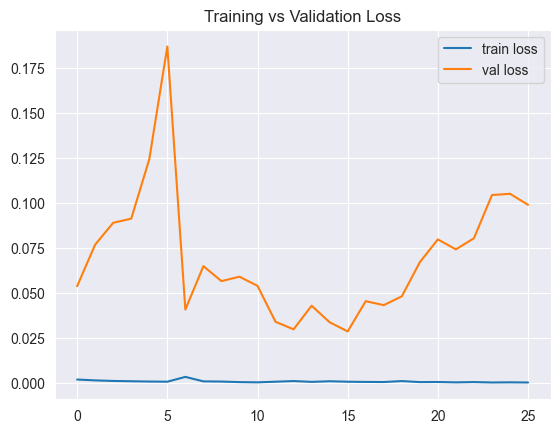

In [25]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# 11. Model evaluation

In [26]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

1033/1033 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9999 - loss: 3.8982e-04
Test Accuracy: 0.9999


## 11.1. Classification report

In [28]:
y_pred = np.argmax(model.predict(X_test), axis=1)

labels = np.unique(np.concatenate([y_test, y_pred]))

print(
    classification_report(
        y_test,
        y_pred,
        labels=labels,
        target_names=le.inverse_transform(labels),
        zero_division=0
    )
)

1033/1033 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00     33041
  RECOVERING       0.00      0.00      0.00         0

    accuracy                           1.00     33041
   macro avg       0.50      0.50      0.50     33041
weighted avg       1.00      1.00      1.00     33041



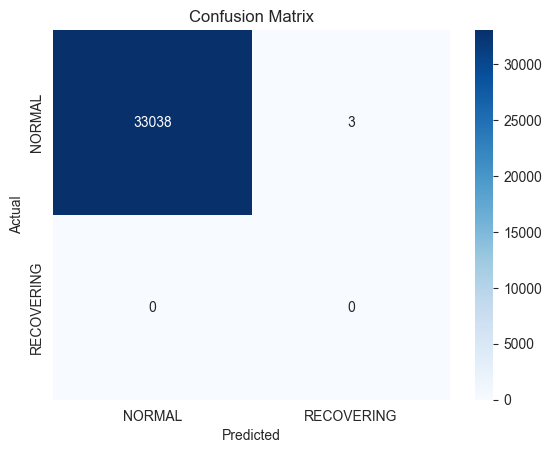

In [31]:
labels = np.unique(np.concatenate([y_test, y_pred]))
class_names = le.inverse_transform(labels)

cm = confusion_matrix(y_test, y_pred, labels=labels)

sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [33]:
# save trained model
model.save("pump_lstm_model.keras")